In [1]:
import os
from pyspark.sql import SparkSession
from IPython.display import display
import matplotlib.pyplot as plt



In [2]:
import findspark
findspark.init()
findspark.find()

'C:\\Program Files\\Spark\\spark-3.5.1-bin-hadoop3'

In [3]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("My Spark App") \
    .getOrCreate()

# EDA

In [4]:
cleaned_df = spark.read.csv("cleaned_songs.csv", header=True, inferSchema=True)

print(cleaned_df.count())

18184


In [5]:
from pyspark.sql import functions as F
# features : danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms

# draw distribution of each audio feature

features = ["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms"]

# transform genre column to string array 
genres = cleaned_df.select("playlist_genre").distinct().select(F.collect_list('playlist_genre')).first()[0]




In [6]:

for feature in features:
    display(cleaned_df.select(feature).summary().toPandas())

,summary,danceability
0,count,18184
1,mean,0.6442043004839418
2,stddev,0.15012583733803528
3,min,0.116
4,25%,0.545
5,50%,0.66
6,75%,0.7559999999999999
7,max,0.979


,summary,energy
0,count,18184
1,mean,0.6928828090629123
2,stddev,0.17926713617877324
3,min,0.0167
4,25%,0.574
5,50%,0.715
6,75%,0.8340000000000001
7,max,1.0


,summary,key
0,count,18184
1,mean,5.342498900131984
2,stddev,3.6148583732533655
3,min,0.0
4,25%,2.0
5,50%,6.0
6,75%,9.0
7,max,11.0


,summary,loudness
0,count,18184
1,mean,-6.749788275406952
2,stddev,2.893395674596352
3,min,-34.283
4,25%,-8.218
5,50%,-6.221
6,75%,-4.717
7,max,1.275


,summary,mode
0,count,18184
1,mean,0.5822151341838979
2,stddev,0.49320791668275055
3,min,0.0
4,25%,0.0
5,50%,1.0
6,75%,1.0
7,max,1.0


,summary,speechiness
0,count,18184
1,mean,0.10627822261328643
2,stddev,0.10232011216882282
3,min,0.0224
4,25%,0.0396
5,50%,0.0602
6,75%,0.131
7,max,0.918


,summary,acousticness
0,count,18184
1,mean,0.17438678622635276
2,stddev,0.21600116784256618
3,min,1.4E-6
4,25%,0.0163
5,50%,0.0821
6,75%,0.252
7,max,0.992


,summary,instrumentalness
0,count,18184
1,mean,0.04337248021722392
2,stddev,0.1506256884108591
3,min,0.0
4,25%,0.0
5,50%,7.42E-6
6,75%,0.00135
7,max,0.987


,summary,liveness
0,count,18184
1,mean,0.18939507039155312
2,stddev,0.15340515322901194
3,min,0.00936
4,25%,0.0926
5,50%,0.128
6,75%,0.246
7,max,0.996


,summary,valence
0,count,18184
1,mean,0.5228574356577211
2,stddev,0.22761868320033324
3,min,1.0E-5
4,25%,0.34700000000000003
5,50%,0.523
6,75%,0.7020000000000001
7,max,0.991


,summary,tempo
0,count,18184
1,mean,120.79643263308402
2,stddev,27.629675318437013
3,min,37.114
4,25%,98.528
5,50%,120.027
6,75%,136.00799999999998
7,max,214.047


,summary,duration_ms
0,count,18184
1,mean,230549.0757259129
2,stddev,56735.896677169534
3,min,31893.0
4,25%,193594.0
5,50%,221467.0
6,75%,258027.0
7,max,517810.0


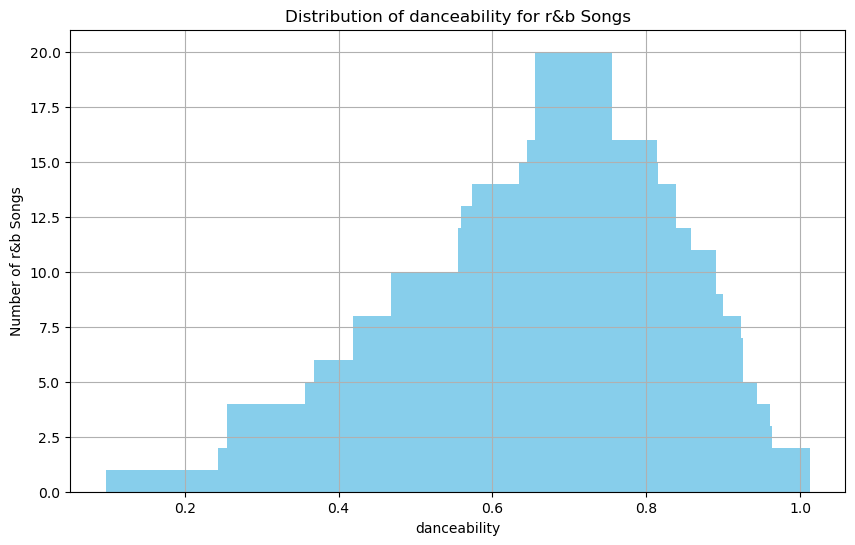

KeyboardInterrupt: 

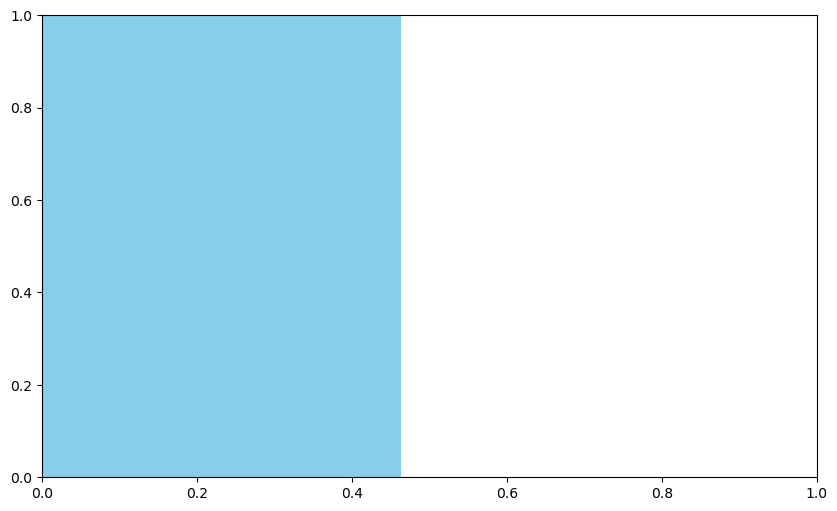

In [7]:
#draw distribution of each audio feature with each genre as a bar chart

# Assuming spark is your SparkSession and df is your DataFrame

for genre in genres:
    for feature in features:
        # Filter the DataFrame to include only rows belonging to the current genre
        genre_songs_df = cleaned_df.filter(cleaned_df.playlist_genre == genre)

        # Group by feature and count the number of songs for each feature
        feature_counts = genre_songs_df.groupBy(feature).count().orderBy(feature)

        # Convert Spark DataFrame to Pandas DataFrame for plotting
        feature_counts_pd = feature_counts.toPandas()

        # Plot the graph
        plt.figure(figsize=(10, 6))
        plt.bar(feature_counts_pd[feature], feature_counts_pd['count'], color='skyblue'  , width=0.1)
        plt.xlabel(feature)
        plt.ylabel('Number of {} Songs'.format(genre))
        plt.title('Distribution of {} for {} Songs'.format(feature, genre))
        plt.grid(True)
        plt.show()
        
        
        